# NBA 2018-2019 Season Analysis

For this project, we will analyze the NBA 2018-2019 season based on players' per-game and advanced stats.  In particular, we will separate the stats into two groups based on whether they relate to a player's performance on offense or defense.  We will then perform clustering on players' offensive and defensive stats separately.  Our motivation is to extract some insights into the types of roles players assume on both sides of the ball and to find out who the elite two-way players are. 

The data was obtained from Basketball Reference (click [here](https://www.basketball-reference.com/leagues/NBA_2019_per_game.html) for per-game stats and [here](https://www.basketball-reference.com/leagues/NBA_2019_advanced.html) for advanced stats).  For column definitions, click on "Glossary" in the two aforementioned links.

In [263]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('fivethirtyeight')
pd.options.mode.chained_assignment = None

## 1. Data Processing

The first step in our data analysis is to clean the data.  We have two datasets at our disposal, e.g. the per-game stats and advanced stats.  Let's first preview the datasets by displaying their first five rows.

In [264]:
# Read the data
per_game = pd.read_csv('NBA2018-19PerGameStats.txt')  # Per-game stats
advanced = pd.read_csv('NBA2018-19AdvancedStats.txt')  # Advanced stats

# Remove missing columns
advanced.drop(advanced.columns[[19, 24]], axis=1, inplace=True)

# Preview the data
display(per_game.head())
advanced.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Álex Abrines\abrinal01,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,28,23.3,3.4,5.9,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Álex Abrines\abrinal01,SG,25,OKC,31,588,6.3,0.507,0.809,...,7.9,12.2,0.1,0.6,0.6,0.053,-3.7,0.4,-3.3,-0.2
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,123,2.9,0.379,0.833,...,15.2,9.2,-0.1,0.0,-0.1,-0.022,-7.6,-0.5,-8.1,-0.2
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,428,7.6,0.474,0.673,...,19.7,13.5,-0.1,0.2,0.1,0.011,-3.8,-0.5,-4.3,-0.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,2669,18.5,0.591,0.002,...,12.6,16.4,5.1,4.0,9.1,0.163,0.7,0.4,1.1,2.1
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,1913,17.9,0.623,0.031,...,17.1,15.8,3.4,3.4,6.8,0.171,-0.4,2.2,1.8,1.8


Inspection of the datasets shows that some players have multiple rows of data; these are players that played for more than one team.  The first row for these players is their aggregated stats, which we want to keep; we can drop the other rows that correspond to stats for each team they played for.

After dropping the redundant columns such as 'Rk' and 'Pos' from the advanced stats, we can merge the two datasets.

In [265]:
# Keep only totals for players with multiple rows (players that played for more than one team)
per_game.drop_duplicates(subset=['Rk'], inplace=True)
advanced.drop_duplicates(subset=['Rk'], inplace=True)

# Drop redundant columns from advanced
advanced.drop(['Rk', 'Pos', 'Age', 'Tm', 'G', 'MP'], axis=1, inplace=True)

# Merge per_game and advanced
data = pd.merge(per_game, advanced, how='left', on='Player')

# Remove the 8 players listed with multiple positions
data = data[data.Pos.isin(['PG', 'SG', 'SF', 'PF', 'C'])]

# Clean the Player column
data['Player'] = data['Player'].map(lambda x: x.split('\\')[0])

# Set the Rk column as index
data.set_index('Rk', inplace=True)

# Preview the merged data
data.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
Rk,,,,,,,,,,,,,,,,,,,,,
1,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,...,7.9,12.2,0.1,0.6,0.6,0.053,-3.7,0.4,-3.3,-0.2
2,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,0.222,...,15.2,9.2,-0.1,0.0,-0.1,-0.022,-7.6,-0.5,-8.1,-0.2
3,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,...,19.7,13.5,-0.1,0.2,0.1,0.011,-3.8,-0.5,-4.3,-0.2
4,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,0.595,...,12.6,16.4,5.1,4.0,9.1,0.163,0.7,0.4,1.1,2.1
5,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,0.576,...,17.1,15.8,3.4,3.4,6.8,0.171,-0.4,2.2,1.8,1.8


For our analysis, we want to remove players players that played less than half the season (41 games) and less than 20 minutes per game.  There are many of these players that played low minutes, which can skew our analysis.  We do this because we want to focus our analysis on the players that played significant minutes and thus are vital contributors to their teams.  In addition, we replace missing values with 0 since they correspond to undefined percentages; for example, a player who has not attempted a 3-point field goal will have a missing value in the '3P%' column.

After performing all these data processing tasks, we are left with 225 players or rows and 49 columns.

In [266]:
# Remove players that played less than half the season and less than 20 minutes per game
data = data[(data.G >= 41) & (data.MP >= 20)]

# Replace missing values with 0
data.fillna(0, inplace=True)

# Final data dimensions
data.shape

(225, 49)

## 2. Exploratory Data Analysis

We begin our exploratory data analysis by looking at the summary statisics of the data.  We see, for example, that the average age is 26, the average points per game is 13.4, and the average TS% (True shooting percentage, which is a measure of shooting efficiency) is 56.1%. 

In [267]:
# Summary statistics (per-game stats)
data.iloc[:, :28].describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,...,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,26.155556,69.564444,47.164444,27.683111,4.958222,10.683556,0.463689,1.355556,3.774222,0.330822,...,2.791556,0.767440,1.155111,4.048000,5.200889,3.007111,0.896000,0.564000,1.627556,2.266667
std,3.892275,11.157820,26.259770,4.486555,1.995584,4.086404,0.060480,0.859961,2.216064,0.088227,...,1.852308,0.090053,0.931964,1.889139,2.641682,1.968285,0.362693,0.478551,0.802866,0.560054
min,19.000000,42.000000,0.000000,20.000000,1.500000,4.000000,0.337000,0.000000,0.000000,0.000000,...,0.400000,0.417000,0.200000,1.400000,1.700000,0.500000,0.100000,0.000000,0.300000,1.100000
25%,23.000000,64.000000,24.000000,23.900000,3.400000,7.400000,0.422000,0.800000,2.500000,0.323000,...,1.400000,0.716000,0.500000,2.700000,3.300000,1.500000,0.600000,0.300000,1.000000,1.900000
50%,26.000000,73.000000,52.000000,27.500000,4.400000,9.700000,0.448000,1.300000,3.700000,0.348000,...,2.400000,0.783000,0.800000,3.600000,4.500000,2.400000,0.800000,0.400000,1.500000,2.200000
75%,29.000000,79.000000,72.000000,31.400000,6.000000,13.000000,0.487000,1.900000,5.000000,0.372000,...,3.500000,0.836000,1.400000,5.000000,6.500000,3.900000,1.100000,0.700000,2.000000,2.600000
max,37.000000,82.000000,82.000000,36.900000,10.800000,24.500000,0.694000,5.100000,13.200000,0.529000,...,11.000000,0.928000,5.400000,11.100000,15.600000,10.700000,2.200000,2.700000,5.000000,3.800000


In [268]:
# Summary statistics (advanced stats)
data.iloc[:, 28:].describe()

,PTS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,...,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,13.427556,15.496444,0.561449,0.364249,0.251338,4.499556,15.571111,10.033778,15.761333,1.535556,...,11.947556,20.319556,2.384889,2.006222,4.389333,0.104316,0.321778,0.058667,0.379556,1.311556
std,5.649490,4.829623,0.044260,0.187072,0.108984,3.533166,6.369845,4.663289,9.129684,0.513894,...,3.195715,5.529537,2.203071,1.101118,2.936527,0.057580,2.405206,1.186655,2.813683,1.666677
min,4.300000,6.000000,0.417000,0.000000,0.068000,0.700000,6.000000,3.800000,4.100000,0.300000,...,3.700000,9.500000,-2.800000,-0.500000,-1.700000,-0.045000,-5.200000,-3.300000,-6.000000,-2.000000
25%,9.300000,12.000000,0.534000,0.255000,0.169000,2.100000,10.900000,6.600000,8.800000,1.100000,...,9.700000,16.400000,0.900000,1.200000,2.300000,0.062000,-1.300000,-0.700000,-1.600000,0.200000
50%,11.900000,14.400000,0.561000,0.367000,0.231000,3.100000,14.100000,8.700000,12.500000,1.500000,...,11.500000,19.300000,2.000000,1.800000,3.700000,0.100000,-0.100000,0.100000,0.000000,1.000000
75%,16.600000,18.500000,0.588000,0.500000,0.312000,5.400000,18.900000,12.400000,21.200000,1.900000,...,13.800000,23.800000,3.700000,2.800000,6.100000,0.134000,1.400000,0.800000,1.600000,1.900000
max,36.100000,30.900000,0.692000,0.814000,0.733000,16.800000,35.600000,25.900000,46.500000,3.100000,...,26.800000,40.500000,11.400000,5.900000,15.200000,0.292000,9.400000,4.100000,11.000000,9.300000


Interestingly, the number of players for each position (PG, SG, SF, PF, C) is not quite uniform: there is a prevalence of point guards (PG) and shooting guards (PG).

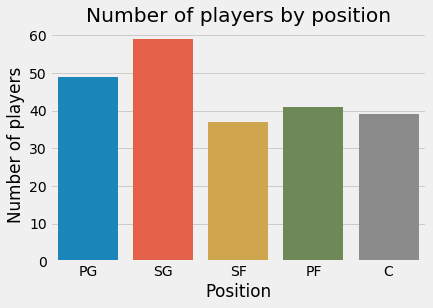

In [269]:
# Reorder positions
data.Pos = data.Pos.astype('category')
data.Pos.cat.reorder_categories(['PG', 'SG', 'SF', 'PF', 'C'], inplace=True)

# Number of players by position
sns.countplot(x='Pos', data=data)
plt.xlabel('Position')
plt.ylabel('Number of players')
plt.title('Number of players by position');

If we group the players by position, we can get an idea for the roles and contributions of each position.  It's no surprise that point guards average the most AST (assists per game) and centers average the most TRB (total rebounds per game).

In [270]:
# Counting stats by position
data.groupby('Pos')[['PTS', 'TRB', 'AST', 'TOV', 'STL', 'BLK']].mean().round(2)

,PTS,TRB,AST,TOV,STL,BLK
Pos,,,,,,
PG,13.95,3.82,5.22,2.04,1.07,0.31
SG,13.42,3.47,2.63,1.47,0.85,0.32
SF,12.62,4.78,2.41,1.43,0.96,0.47
PF,12.90,6.20,2.19,1.51,0.77,0.62
C,14.12,8.91,2.23,1.65,0.81,1.28


In [271]:
# Efficiency measures by position
data.groupby('Pos')[['FG%', 'FGA', '3P%', '3PA', 'FT%', 'FTA', 'TS%']].mean().round(2)

,FG%,FGA,3P%,3PA,FT%,FTA,TS%
Pos,,,,,,,
PG,0.44,11.48,0.34,4.24,0.79,2.89,0.54
SG,0.43,11.15,0.36,4.94,0.79,2.36,0.55
SF,0.45,10.12,0.34,3.93,0.75,2.63,0.55
PF,0.47,10.03,0.35,3.70,0.77,2.75,0.57
C,0.56,10.19,0.23,1.36,0.72,3.52,0.61


The plot of points per game by true shooting percentage shows James Harden of the Houston Rockets as an outlier: his league leading 36.1 points per game is well above the 28 points per game of the second leading scorer, Paul George.  Another outlier is Frank Ntilikina of the New York Knicks who scored 5.7 points per game on 41.7 TS%.  In the bottom right of the graph, we see that there are a few centers who scores very efficiently but not much in terms of volume.

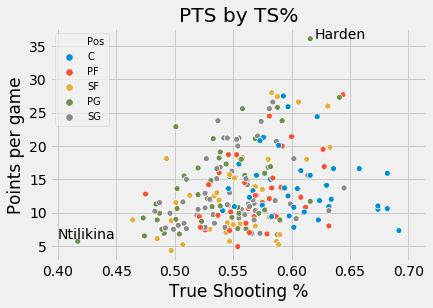

In [272]:
plt.rc('legend', fontsize=10)

# Scatter plot of PPG by TS%
g = sns.scatterplot(x='TS%', y='PTS', data=data, hue='Pos')
plt.xlabel('True Shooting %')
plt.ylabel('Points per game')
plt.title('PTS by TS%')
plt.legend(loc='upper left')
plt.annotate(s='Harden', xy=(0.62, 36.1))
plt.annotate(s='Ntilikina', xy=(0.4, 6));

The plot of turnovers per game by assists per game shows Harden and Westbrook as outliers.  Harden leads the league in turnovers per game, and Westbrook leads the league in assists per game and is also second in turnovers per game. 

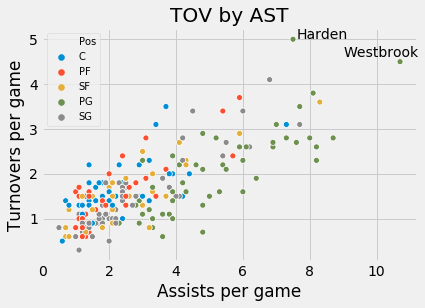

In [273]:
# Scatter plot of TOV by AST
g = sns.scatterplot(x='AST', y='TOV', data=data, hue='Pos')
plt.xlabel('Assists per game')
plt.ylabel('Turnovers per game')
plt.title('TOV by AST')
plt.annotate(s='Harden', xy=(7.6, 5))
plt.annotate(s='Westbrook', xy=(9, 4.6));

## 3. *k*-means Clustering

For the clustering analysis, we want to first separate the features by whether they relate to offense or defense.  For example, 'PTS' (points per game) and 'FG%' (field goal percentage) are offensive features, and 'DRB' (defensive rebounds) and 'STL' (steals) are defensive features.  After separating the features into offensive and defensive groups, we can perform clustering on each group, which can provide us insight into players' roles and contributions on offense and defense.  Note that due to the nature of the sport, there are more offensive stats that are tracked than defensive stats.

The clustering method we will use is k-means clustering.  In k-means clustering, we must specify k, which is the number of clusters and is an integer ranging from one to the number of data points.  Intuitively, grouping all of the data points into one cluster or individual clusters is not informative, so some intermediate value for k is preferred.  The way the k-means clustering algorithm works is by first creating k random cluster centers or centroids.  Each data point is assigned to the closest cluster center.  The cluster centers are then recalculated based on the mean position of all the data points that are assigned to each cluster center.  This process repeats until none of the data points can be assigned to a different cluster.

In [274]:
# List of offensive stats
offense_features = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'AST', 'TOV', 
                    'PTS', 'TS%', '3PAr', 'FTr', 'ORB%', 'AST%', 'TOV%', 'USG%', 'OWS', 'OBPM']
# List of defensive stats
defense_features = ['DRB', 'STL', 'BLK', 'DRB%', 'STL%', 'BLK%', 'DWS', 'DBPM']

# Dataframe of offensive stats
data_offense = data[offense_features]
# Dataframe of defensive stats
data_defense = data[defense_features]

data_offense.describe()

,FG,FGA,FG%,3P,3PA,3P%,eFG%,FT,FTA,FT%,...,PTS,TS%,3PAr,FTr,ORB%,AST%,TOV%,USG%,OWS,OBPM
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,...,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,4.958222,10.683556,0.463689,1.355556,3.774222,0.330822,0.528769,2.159111,2.791556,0.767440,...,13.427556,0.561449,0.364249,0.251338,4.499556,15.761333,11.947556,20.319556,2.384889,0.321778
std,1.995584,4.086404,0.060480,0.859961,2.216064,0.088227,0.045289,1.504048,1.852308,0.090053,...,5.649490,0.044260,0.187072,0.108984,3.533166,9.129684,3.195715,5.529537,2.203071,2.405206
min,1.500000,4.000000,0.337000,0.000000,0.000000,0.000000,0.395000,0.300000,0.400000,0.417000,...,4.300000,0.417000,0.000000,0.068000,0.700000,4.100000,3.700000,9.500000,-2.800000,-5.200000
25%,3.400000,7.400000,0.422000,0.800000,2.500000,0.323000,0.498000,1.100000,1.400000,0.716000,...,9.300000,0.534000,0.255000,0.169000,2.100000,8.800000,9.700000,16.400000,0.900000,-1.300000
50%,4.400000,9.700000,0.448000,1.300000,3.700000,0.348000,0.525000,1.800000,2.400000,0.783000,...,11.900000,0.561000,0.367000,0.231000,3.100000,12.500000,11.500000,19.300000,2.000000,-0.100000
75%,6.000000,13.000000,0.487000,1.900000,5.000000,0.372000,0.557000,2.700000,3.500000,0.836000,...,16.600000,0.588000,0.500000,0.312000,5.400000,21.200000,13.800000,23.800000,3.700000,1.400000
max,10.800000,24.500000,0.694000,5.100000,13.200000,0.529000,0.694000,9.700000,11.000000,0.928000,...,36.100000,0.692000,0.814000,0.733000,16.800000,46.500000,26.800000,40.500000,11.400000,9.400000


### 3a. Clustering on Offensive Stats

Before we begin our clustering analysis, we must standardize the data to have mean 0 and variance 1.  This is due to differences in scale among the different features.  For example, 'PTS' (points per game) range from 4.3 to 36.1 while 'FTr' (free throw attempt rate) range from 0.07 to 0.73.  Without standardization, 'PTS' would have more influence on clustering than 'STL'.  We standardize the data so that the features are equally weighed.

Next, we apply principal components analysis (PCA) to reduce the number of features in the data.  PCA is a dimensionality reduction technique that can summarize the data with a smaller number of "principal components" that explain most of the variability in the data.  These principal components are derived from linear transformations of the original features.  To determine the number of principal components to keep, we look at the plot of cumulative proportion of variance explained (PVE) vs. number of principal components (see below).  We want to keep about 80% of the variance, so in this case, we want to keep three principal components.

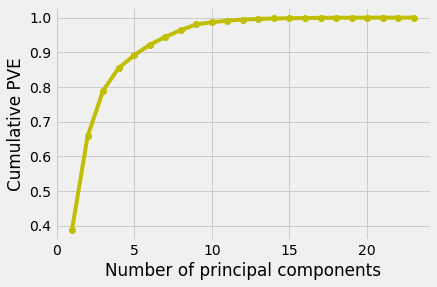

In [275]:
# Scale the features to have mean 0 and variance 1
scaler = StandardScaler()
data_offense_scaled = scaler.fit_transform(data_offense)

# Apply PCA
pca = PCA()
pca.fit(data_offense_scaled)

# Plot of explained variance vs. number of PCA components
n_components = range(1, pca.n_components_+1)
plt.plot(n_components, pca.explained_variance_ratio_.cumsum(), '-o', c='y')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative PVE');

After standardizing and applying PCA to the data, we can formally begin our clustering analysis.  With k-means clustering, we need to determine the number of clusters to create since the algorithm does not do that for us.  We can do this with an inertia plot (see below).  Inertia measures the distance from each data point to the center of its assigned cluster.  We want to minimize inertia to minimize the spread of the clusters.  On the inertia plot, we look for an "elbow" where the inertia changes from sharply decreasing to slowly decreasing; in this case, we choose five as the number of clusters.

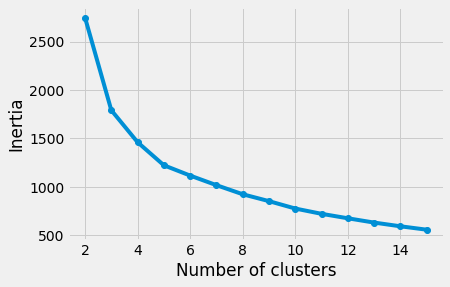

In [276]:
# Apply PCA with 3 components
pca = PCA(n_components=3)
data_offense_pca = pca.fit_transform(data_offense_scaled)

ks = range(2, 16)
inertias = []

# Calculate inertia for 2 to 15 clusters
for k in ks:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(data_offense_pca)
    inertias.append(model.inertia_)
    
# Plot of inertia vs. number of clusters
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

Finally, we initialize a k-means model with five as the number of clusters.  Then we fit the k-means model on the PCA transformed data and obtain the predicted cluster labels for each player.

In [277]:
# Create a KMeans model with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=1)

# Fit KMeans model to data and predict cluster labels
data_offense['cluster_off'] = kmeans.fit_predict(data_offense_pca)
data_offense['cluster_off'] = data_offense['cluster_off'].astype('category')

To get an idea of the clustering results, we can create scatter plots such as the "PTS by TS%" and "OBPM by OWS" plots below.  We see that there is overlap among the clusters; nevertheless, we should be able extract some interesting insights since there is decent cluster separation.

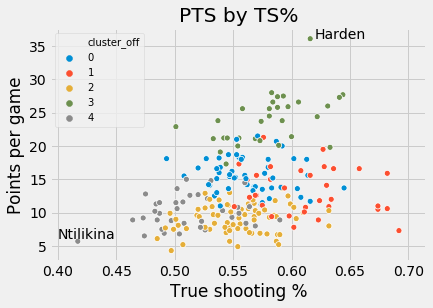

In [278]:
# Scatter plot of PPG by TS%
g = sns.scatterplot(x='TS%', y='PTS', data=data_offense, hue='cluster_off')
plt.xlabel('True shooting %')
plt.ylabel('Points per game')
plt.title('PTS by TS%');
plt.annotate(s='Harden', xy=(0.62, 36.1))
plt.annotate(s='Ntilikina', xy=(0.4, 6));

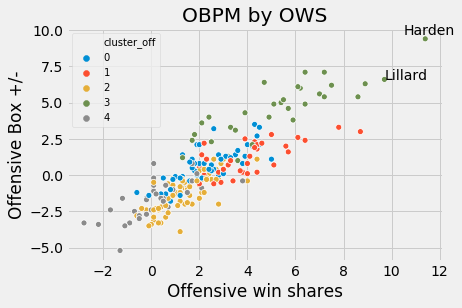

In [279]:
# Scatter plot of PPG by TS%
g = sns.scatterplot(x='OWS', y='OBPM', data=data_offense, hue='cluster_off')
plt.xlabel('Offensive win shares')
plt.ylabel('Offensive Box +/-')
plt.title('OBPM by OWS')
plt.annotate(s='Harden', xy=(10.5, 9.7))
plt.annotate(s='Lillard', xy=(9.7, 6.6));

The average stats for each offensive cluster are shown in the table below.  We will attempt to make some generalizations about each group based on these stats.  We must keep in mind that these groupings are not perfect since players may fit into multiple roles or not have well-defined roles.   

**Cluster 0**: Secondary star (great playmaker who is the Robin to the superstar's Batman)

**Cluster 1**: Inside scorer and rebounder (scorer who primarily scores inside the 3-point line and grabs offensive rebounds)

**Cluster 2**: Role player (low usage player that does not have a significant role on offense)

**Cluster 3**: Offensive superstar (best of the best)

**Cluster 4**: Inefficient scorer (player who barely, if not negatively, contributes to team's offense and scores inefficiently)

In [280]:
# Offensive stats by cluster
data_offense.groupby('cluster_off')[['PTS', 'ORB', 'AST', 'TOV', 'USG%', 'OWS', 'OBPM', 'FG%', 
                                     'FGA', '3P%', '3PA', 'FT%', 'FTA', 'TS%']].mean().round(2)

,PTS,ORB,AST,TOV,USG%,OWS,OBPM,FG%,FGA,3P%,3PA,FT%,FTA,TS%
cluster_off,,,,,,,,,,,,,,
0,15.64,0.81,3.23,1.70,22.07,2.37,0.67,0.45,12.70,0.37,5.05,0.82,2.85,0.56
1,13.20,2.79,1.99,1.57,19.85,4.04,1.17,0.57,9.41,0.21,0.78,0.69,3.39,0.61
2,9.01,0.75,1.74,0.94,15.58,1.41,-1.20,0.43,7.55,0.36,3.99,0.77,1.35,0.55
3,23.98,1.29,5.77,2.99,29.85,5.27,4.56,0.47,17.93,0.35,5.83,0.81,6.15,0.58
4,10.07,0.75,3.79,1.77,19.38,0.24,-1.66,0.43,8.94,0.32,2.66,0.72,2.06,0.51


If we look at the number of players in each cluster, we see that cluster 2 is the largest group with 71 players, which makes sense since we had described this cluster as "role players".

In [281]:
# Number of players in each cluster
data_offense['cluster_off'].value_counts()

2    71
0    52
4    36
1    35
3    31
Name: cluster_off, dtype: int64

As a final exercise to satisfy our intuition, the top five players in terms of 'OWS' (offensive win shares) from each cluster are listed below.  Overall, k-means did a decent job clustering the players.  For example, we see offensive superstars such as Harden and Lillard in cluster 3 and inside scorers such as Gobert and Capela in cluster 1.   

In [282]:
data_offense['Player'] = data['Player']
for cluster in sorted(data_offense['cluster_off'].unique()):
    print(cluster, data_offense[data_offense['cluster_off'] == cluster].sort_values('OWS', ascending=False)['Player'].values[:5])

0 ['D.J. Augustin' 'J.J. Redick' 'Al Horford' 'Tobias Harris' 'Chris Paul']
1 ['Rudy Gobert' 'Clint Capela' 'LaMarcus Aldridge' 'Montrezl Harrell'
 'Pascal Siakam']
2 ['Monte Morris' 'Jerami Grant' 'Al-Farouq Aminu' 'Danny Green'
 'Malik Beasley']
3 ['James Harden' 'Damian Lillard' 'Giannis Antetokounmpo' 'Kevin Durant'
 'Nikola Jokić']
4 ['Tomáš Satoranský' 'Tyus Jones' 'Delon Wright' 'Derrick White'
 'Jeff Teague']


### 3b. Clustering on Defensive Stats

Repeating the same steps for clustering on offensive stats, we standardize and apply PCA to the data.  Based on the plot of cumulative proportion of variance explained (PVE) vs. number of principal components, we want to keep two principal components. 

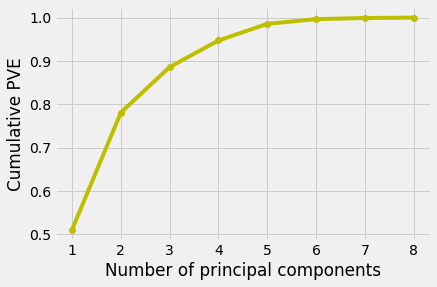

In [283]:
# Scale the features to have mean 0 and variance 1
scaler = StandardScaler()
data_defense_scaled = scaler.fit_transform(data_defense)

# Apply PCA
pca = PCA()
pca.fit(data_defense_scaled)

# Plot of explained variance vs. number of PCA components
n_components = range(1, pca.n_components_+1)
plt.plot(n_components, pca.explained_variance_ratio_.cumsum(), '-o', c='y')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative PVE');

Based on the inertia plot, we choose five as the number of clusters.

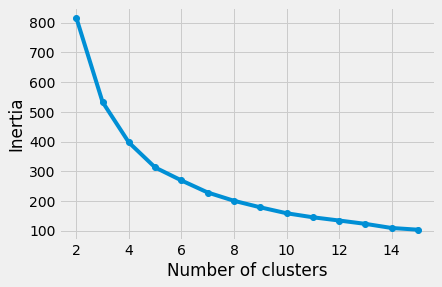

In [284]:
# Apply PCA with 2 components
pca = PCA(n_components=2)
data_defense_pca = pca.fit_transform(data_defense_scaled)

ks = range(2, 16)
inertias = []

# Calculate inertia for 2 to 15 clusters
for k in ks:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(data_defense_pca)
    inertias.append(model.inertia_)
    
# Plot of inertia vs. number of clusters
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

Finally, we initialize a k-means model with five as the number of clusters.  Then we fit the k-means model on the PCA transformed data and obtain the predicted cluster labels for each player.

In [285]:
# Create a KMeans model with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=1)

# Fit KMeans model to data and predict cluster labels
data_defense['cluster_def'] = kmeans.fit_predict(data_defense_pca)
data_defense['cluster_def'] = data_defense['cluster_def'].astype('category')

Similar to the "PTS by TS%" and "OBPM by OWS" plots, we see overlap among the clusters, but there is enough separation to see the overall trend.

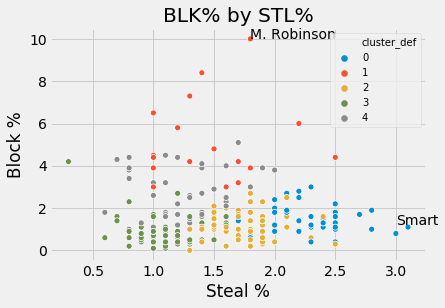

In [286]:
# Scatter plot of BLK% by STL%
g = sns.scatterplot(x='STL%', y='BLK%', data=data_defense, hue='cluster_def')
plt.xlabel('Steal %')
plt.ylabel('Block %')
plt.title('BLK% by STL%')
plt.annotate(s='M. Robinson', xy=(1.8, 10))
plt.annotate(s='Smart', xy=(3.0, 1.2));

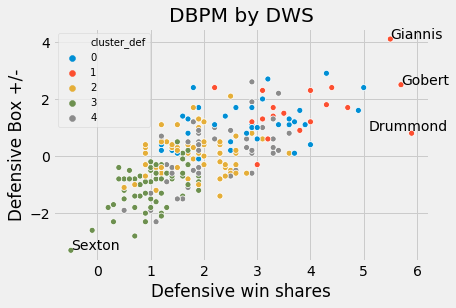

In [287]:
# Scatter plot of DBPM by DWS
g = sns.scatterplot(x='DWS', y='DBPM', data=data_defense, hue='cluster_def')
plt.xlabel('Defensive win shares')
plt.ylabel('Defensive Box +/-')
plt.title('DBPM by DWS')
plt.annotate(s='Giannis', xy=(5.5, 4.1))
plt.annotate(s='Gobert', xy=(5.7, 2.5))
plt.annotate(s='Sexton', xy=(-0.5, -3.3))
plt.annotate(s='Drummond', xy=(5.1, 0.9));

The average stats for each defensive cluster are shown in the table below.  Similar to what we did with offensive clusters, we will attempt to make some generalizations about each group based on these stats.     

**Cluster 0**: Pickpocket (player who is adept at steals and forcing turnovers)

**Cluster 1**: Rim protector and rebounder (shot blocker who also rebounds)

**Cluster 2**: Perimeter defender (player who primarily defends outside of the paint)

**Cluster 3**: Bad defender (self-explanatory)

**Cluster 4**: All-around defender (player who can do a little of everything on defense)

In [288]:
# Defensive stats by cluster
data_defense.groupby('cluster_def')[['DRB', 'STL', 'BLK', 'DRB%', 'STL%', 'BLK%', 'DWS', 'DBPM']].mean().round(2)

,DRB,STL,BLK,DRB%,STL%,BLK%,DWS,DBPM
cluster_def,,,,,,,,
0,4.52,1.49,0.54,15.76,2.33,1.50,2.82,1.14
1,7.61,0.89,1.76,27.33,1.46,5.27,3.88,1.66
2,3.18,0.97,0.37,12.51,1.72,1.16,1.83,0.04
3,2.69,0.61,0.27,11.08,1.10,0.90,1.03,-1.05
4,5.28,0.70,0.77,21.04,1.25,2.53,2.17,0.08


The number of players in each cluster shows us that rim protectors are rare; this makes sense as the league average for blocks per game is about 0.56.

In [289]:
# Number of players in each cluster
data_defense['cluster_def'].value_counts()

2    64
3    61
4    46
0    36
1    18
Name: cluster_def, dtype: int64

The top five players in terms of 'DWS' (defensive win shares) from each cluster are listed below.  We see pickpockets such as Westbrook and George in cluster 0 and rim protectors such as Gobert and Giannis in cluster 1.

In [290]:
data_defense['Player'] = data['Player']
for cluster in sorted(data_defense['cluster_def'].unique()):
    print(cluster, data_defense[data_defense['cluster_def'] == cluster].sort_values('DWS', ascending=False)['Player'].values[:5])

0 ['Russell Westbrook' 'Paul George' 'Nikola Jokić' 'Steven Adams'
 'Thaddeus Young']
1 ['Andre Drummond' 'Rudy Gobert' 'Giannis Antetokounmpo' 'Nikola Vučević'
 'Myles Turner']
2 ['Khris Middleton' 'Jae Crowder' 'Danny Green' 'Bojan Bogdanović'
 'Justise Winslow']
3 ['D.J. Augustin' 'Kyle Kuzma' 'Reggie Jackson' 'CJ McCollum' 'Joe Harris']
4 ['Pascal Siakam' 'Bam Adebayo' 'Jayson Tatum' 'Aaron Gordon'
 'Domantas Sabonis']


## 4. Conclusion

Now that we have offensive and defensive cluster labels for players, we might be curious about who the elite two-way players.  We choose cluster 3 of the offensive groupings as the elite offensive players and clusters 0 and 1 of the defensive groupings as the elite defensive players.  In terms of the generalizations applied to clusters, elite offensive players are "offensive superstars" and elite defensive players are "pickpockets" or "rim protectors".  The results are shown below.  

Caveats to keep in mind are that defensive metrics are highly reliant on team defense; that is, "bad" defenders may have good defensive metrics if surrounded by good defensive teammates.  Furthermore, simply racking up high numbers of rebounds, steals, or blocks does not necessarily indicate a good defender.  There are way more aspects of defense such as ball denial and shot contests that we have not incorporated into the data.

In [291]:
# Players who are elite offensively and defensively
data_labels = pd.concat([data_offense[['Player', 'cluster_off']], data_defense['cluster_def']], axis=1)
data_labels[(data_labels['cluster_off'] == 3) & ((data_labels['cluster_def'] == 0) | (data_labels['cluster_def'] == 1))]

,Player,cluster_off,cluster_def
Rk,,,
18,Giannis Antetokounmpo,3,1
126,Anthony Davis,3,1
155,Joel Embiid,3,1
171,De'Aaron Fox,3,0
183,Paul George,3,0
206,James Harden,3,0
230,Jrue Holiday,3,0
249,Kyrie Irving,3,0
258,LeBron James,3,0
